Начну с подготовки датасета: нужно собрать пользователей и их заказы вместе и посмотреть на данные.

In [161]:
import pandas as pd
import numpy as np

In [162]:
df_orders = pd.read_csv('orders.csv')
df_orders['order_month'] = df_orders['order_date'].apply(lambda x: x[0:7])
df_orders['order_year'] = df_orders['order_date'].apply(lambda x: x[0:4])

In [163]:
df_customers = pd.read_csv('customers.csv')
cols = ['customer_id']
cols.extend(df_customers.columns[1:])
df_customers.columns = cols

In [164]:
df_orders.sample(5)

,id,order_date,ship_mode,customer_id,sales,order_month,order_year
4987,165358,2017-07-18,Standard,SV-20365,807.898,2017-07,2017
4105,165323,2017-06-17,Standard,SR-20740,3505.840,2017-06,2017
264,122217,2014-11-24,Standard,HP-14815,111.150,2014-11,2014
3267,122987,2017-08-16,Same Day,SJ-20215,80.564,2017-08,2017
493,140662,2014-11-17,First,TS-21205,1075.370,2014-11,2014


In [165]:
df_customers.sample(5)

,customer_id,name,segment,state,city
282,JF-15355,Jay Fein,Consumer,Texas,Austin
243,NG-18355,Nat Gilpin,Corporate,New York,New York City
195,AJ-10960,Astrea Jones,Consumer,New York,Rochester
789,RS-19870,Roy Skaria,Home Office,Iowa,Burlington
73,NP-18670,Nora Paige,Consumer,Oklahoma,Edmond


In [166]:
df_merge = pd.merge(df_orders, df_customers, 'inner', on='customer_id')

In [167]:
df_merge.sample(5)

,id,order_date,ship_mode,customer_id,sales,order_month,order_year,name,segment,state,city
1473,117380,2014-03-28,Standard,MP-18175,330.588,2014-03,2014,Mike Pelletier,Home Office,California,Laguna Niguel
1603,138870,2017-06-19,Standard,GA-14515,74.880,2017-06,2017,George Ashbrook,Consumer,California,San Francisco
3317,157651,2017-12-10,Standard,HA-14920,14.200,2017-12,2017,Helen Andreada,Consumer,California,Pasadena
3442,162096,2017-11-10,Same Day,TB-21190,7.800,2017-11,2017,Thomas Brumley,Home Office,Arkansas,Fayetteville
2166,128587,2015-12-24,Standard,HM-14860,4909.610,2015-12,2015,Harry Marie,Corporate,Pennsylvania,Philadelphia


Добавлю информацию о дате первого заказа (его год).

In [168]:
df_first = df_merge.groupby('customer_id')['order_year'].min().reset_index()
df_first.columns = ['customer_id', 'first_order']

In [169]:
df_first.sample(5)

,customer_id,first_order
5,AB-10060,2015
200,DC-13285,2014
761,TS-21160,2014
682,SD-20485,2014
656,RR-19525,2014


In [170]:
df_full = pd.merge(df_merge, df_first, 'inner', on='customer_id')

In [171]:
df_full.sample(5)

,id,order_date,ship_mode,customer_id,sales,order_month,order_year,name,segment,state,city,first_order
4872,112536,2017-05-18,Standard,SG-20890,17.798,2017-05,2017,Susan Gilcrest,Corporate,Texas,Mcallen,2014
3159,133130,2014-09-27,Standard,TH-21100,685.900,2014-09,2014,Thea Hendricks,Consumer,California,Los Angeles,2014
4859,154690,2016-08-15,Second,CC-12370,225.296,2016-08,2016,Christopher Conant,Consumer,North Carolina,Fayetteville,2016
3358,160563,2015-10-20,Standard,NS-18640,255.990,2015-10,2015,Noel Staavos,Corporate,Illinois,Chicago,2014
4686,162572,2017-09-25,Second,RB-19360,130.568,2017-09,2017,Raymond Buch,Consumer,New York,Auburn,2016


Посмотрю на дескриптивную статистику: есть ли пропущенные значения и где. (и что вообще происходит)

In [172]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5009 entries, 0 to 5008
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           5009 non-null   int64  
 1   order_date   5009 non-null   object 
 2   ship_mode    5009 non-null   object 
 3   customer_id  5009 non-null   object 
 4   sales        5009 non-null   float64
 5   order_month  5009 non-null   object 
 6   order_year   5009 non-null   object 
 7   name         5009 non-null   object 
 8   segment      5009 non-null   object 
 9   state        5009 non-null   object 
 10  city         5009 non-null   object 
 11  first_order  5009 non-null   object 
dtypes: float64(1), int64(1), object(10)
memory usage: 508.7+ KB


Отлично, никаких пропущенных значений. Можно переходить к когортному анализу.

In [173]:
df_users = df_full.groupby(['customer_id', 'first_order', 'order_year'])\
    .agg({'sales':'sum', 'id':'count'}).reset_index()

In [174]:
df_users.sample(5)

,customer_id,first_order,order_year,sales,id
2464,VP-21760,2014,2014,734.484,3
2164,SF-20200,2014,2016,54.704,3
2020,RF-19345,2014,2015,268.400,1
1830,ON-18715,2014,2014,609.056,3
968,GM-14680,2014,2016,1031.988,3


In [175]:
df_users['CohortIndex'] = - df_users['first_order'].astype(int) + df_users['order_year'].astype(int) + 1 

In [176]:
df_users

,customer_id,first_order,order_year,sales,id,CohortIndex
0,AA-10315,2014,2014,756.048,2,1
1,AA-10315,2014,2015,26.960,1,2
2,AA-10315,2014,2016,4406.072,1,3
3,AA-10315,2014,2017,374.480,1,4
4,AA-10375,2014,2014,50.792,2,1
...,...,...,...,...,...,...
2494,ZC-21910,2014,2016,3215.733,3,3
2495,ZC-21910,2014,2017,227.066,4,4
2496,ZD-21925,2014,2014,244.760,1,1
2497,ZD-21925,2014,2016,1187.744,3,3


Построим когорты по юзерам:

In [177]:
grouping = df_users.groupby(['first_order', 'CohortIndex'])
cohort_data = grouping['customer_id'].apply(pd.Series.nunique)
cohort_data = cohort_data.reset_index()
cohort_counts = cohort_data.pivot(index='first_order',
                                 columns ='CohortIndex',
                                 values = 'customer_id')
cohort_data.head()


,first_order,CohortIndex,customer_id
0,2014,1,595
1,2014,2,437
2,2014,3,485
3,2014,4,517
4,2015,1,136


In [178]:
cohort_sizes = cohort_counts.iloc[:,0]
retention = cohort_counts.divide(cohort_sizes, axis=0)
retention.round(3)*100

CohortIndex,1,2,3,4
first_order,,,,
2014,100.0,73.4,81.5,86.9
2015,100.0,75.0,88.2,NaN
2016,100.0,88.2,NaN,NaN
2017,100.0,NaN,NaN,NaN


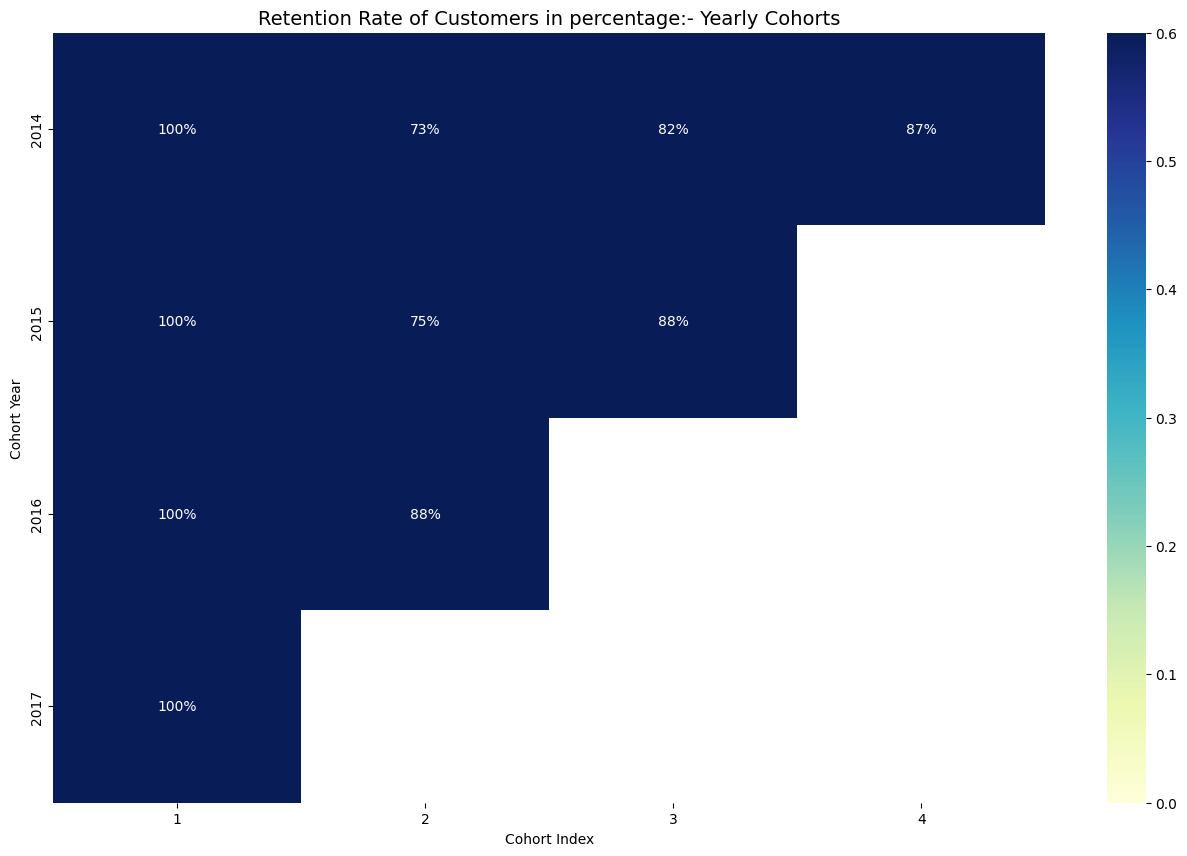

In [179]:
plt.figure(figsize=(16, 10))
plt.title('Retention Rate of Customers in percentage:- Yearly Cohorts', fontsize = 14)
sns.heatmap(retention, annot=True, fmt= '.0%',cmap='YlGnBu', vmin = 0.0 , vmax = 0.6)
plt.ylabel('Cohort Year')
plt.xlabel('Cohort Index')
plt.yticks( rotation='vertical')
plt.show()



В целом retention rate по юзерам в 2016 лучше, чем в 2015-м году. На таком поверхностном уровне никакого оттока юзеров не видно.

Посмотрим по сумме заказа:

In [180]:
grouping = df_users.groupby(['first_order', 'CohortIndex']) 
cohort_data = grouping['sales'].mean()
cohort_data = cohort_data.reset_index() 
average_order = cohort_data.pivot(index='first_order',
                                  columns='CohortIndex',
                                  values='sales')

average_standard_cost = average_order.round(1)

In [181]:
average_standard_cost.head()

CohortIndex,1,2,3,4
first_order,,,,
2014,813.9,835.6,938.0,1031.0
2015,774.9,975.4,1098.1,NaN
2016,1074.6,1353.5,NaN,NaN
2017,682.9,NaN,NaN,NaN


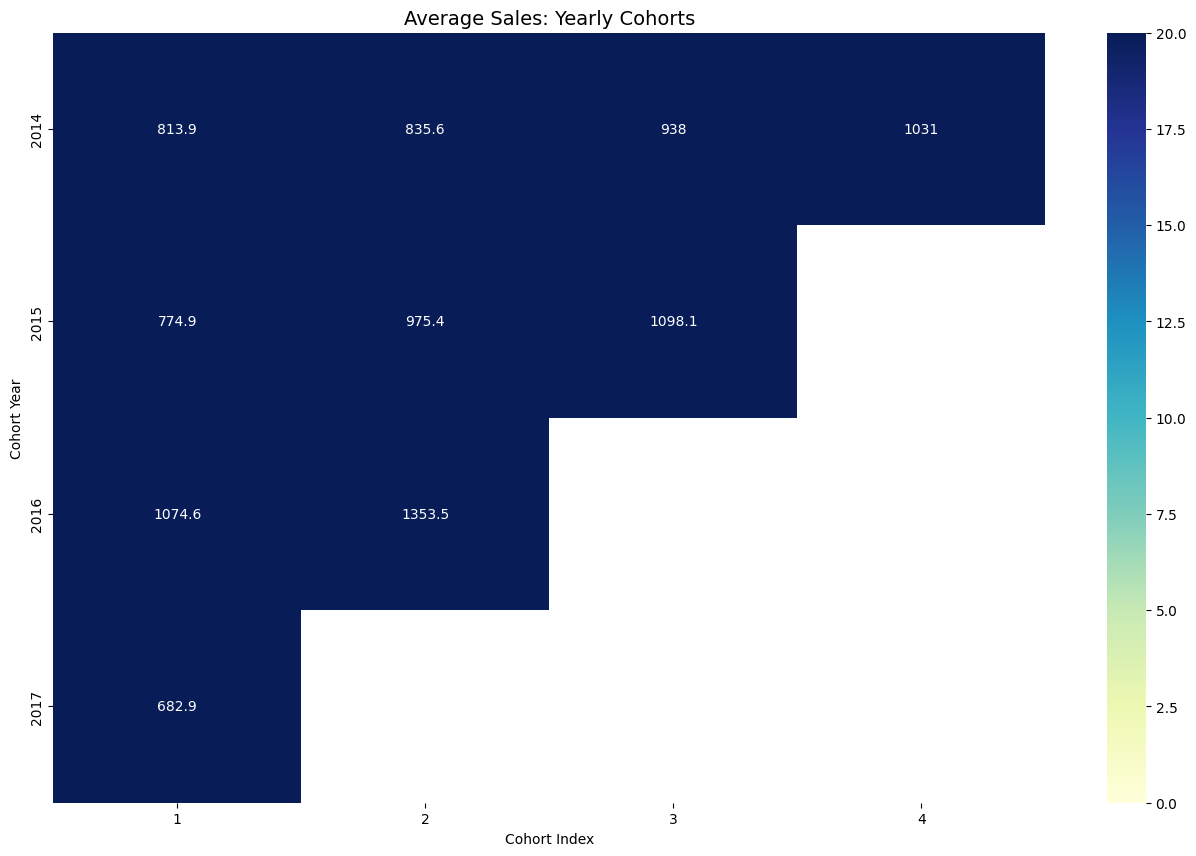

In [182]:
plt.figure(figsize=(16, 10))
plt.title('Average Sales: Yearly Cohorts', fontsize = 14)
sns.heatmap(average_standard_cost, annot = True,vmin = 0.0, vmax =20,cmap="YlGnBu", fmt='g')
plt.ylabel('Cohort Year')
plt.xlabel('Cohort Index')
plt.yticks( rotation='vertical')
plt.show()

Retention по средней сумме заказа тоже стал лучше, чем был в 2015 году. Посмотрим еще по количеству транзакций.

По количеству транзакций:

In [184]:
grouping = df_users.groupby(['first_order', 'CohortIndex'])
cohort_data = grouping['id'].apply(pd.Series.nunique)
cohort_data = cohort_data.reset_index()
cohort_counts = cohort_data.pivot(index='first_order',
                                 columns ='CohortIndex',
                                 values = 'id')
cohort_data.head()

,first_order,CohortIndex,id
0,2014,1,6
1,2014,2,6
2,2014,3,7
3,2014,4,7
4,2015,1,6


In [187]:
cohort_sizes = cohort_counts.iloc[:,0]
retention = cohort_counts.divide(cohort_sizes, axis=0)
retention.round(3)*100

CohortIndex,1,2,3,4
first_order,,,,
2014,100.0,100.0,116.7,116.7
2015,100.0,100.0,116.7,NaN
2016,100.0,160.0,NaN,NaN
2017,100.0,NaN,NaN,NaN


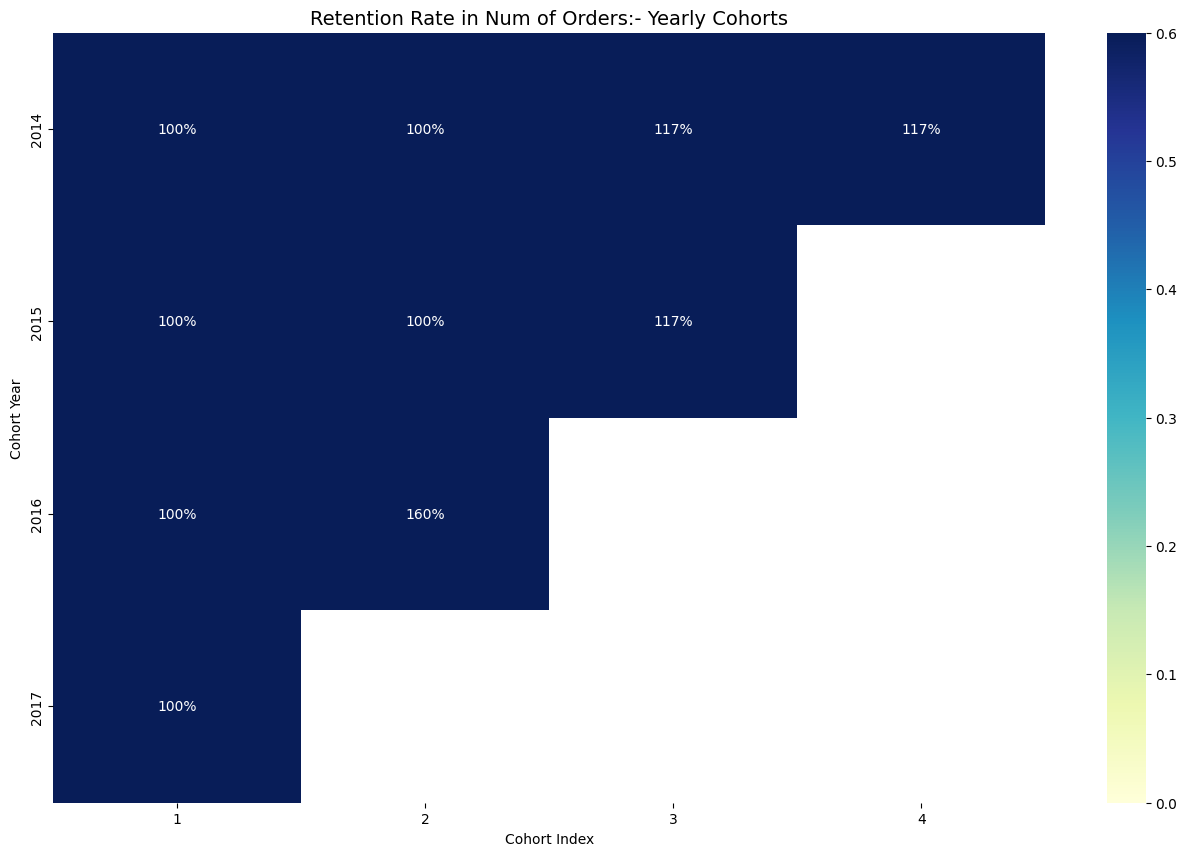

In [188]:
plt.figure(figsize=(16, 10))
plt.title('Retention Rate in Num of Orders:- Yearly Cohorts', fontsize = 14)
sns.heatmap(retention, annot=True, fmt= '.0%',cmap='YlGnBu', vmin = 0.0 , vmax = 0.6)
plt.ylabel('Cohort Year')
plt.xlabel('Cohort Index')
plt.yticks( rotation='vertical')
plt.show()

По количеству заказов Retention в 2016 году тоже веселее. Так что последнее, что можно проверить, это посмотреть, заказы с каким типом доставки обеспечивают этот Retention. В целом оттока пользователей нет, но, возможно, он есть в каком-то конкретном сегменте доставки?

По сегментам:

In [207]:
df_full.ship_mode.unique()

array(['Standard', 'Same Day', 'First', 'Second'], dtype=object)

У нас всего 4 вида доставки. Нарисуем картинку по юзерам для каждого вида.

In [208]:
df_users_categories = df_full.groupby(['customer_id', 'first_order', 'order_year', 'ship_mode'])\
    .agg({'sales':'sum', 'id':'count'}).reset_index()

In [209]:
df_standart = df_users_categories.loc[df_users_categories['ship_mode'] == "Standard"]

In [210]:
df_sameday = df_users_categories.loc[df_users_categories['ship_mode'] == "Same Day"]

In [211]:
df_first = df_users_categories.loc[df_users_categories['ship_mode'] == "First"]

In [212]:
df_second = df_users_categories.loc[df_users_categories['ship_mode'] == "Second"]

In [213]:
df_standart = df_standart.drop("ship_mode", axis = 1)
df_sameday = df_sameday.drop("ship_mode", axis = 1)
df_first = df_first.drop("ship_mode", axis = 1)
df_second = df_second.drop("ship_mode", axis = 1)

In [214]:
dict_names = {0:'Standart', 1:'Same Day', 2:'First', 3:'Second'}

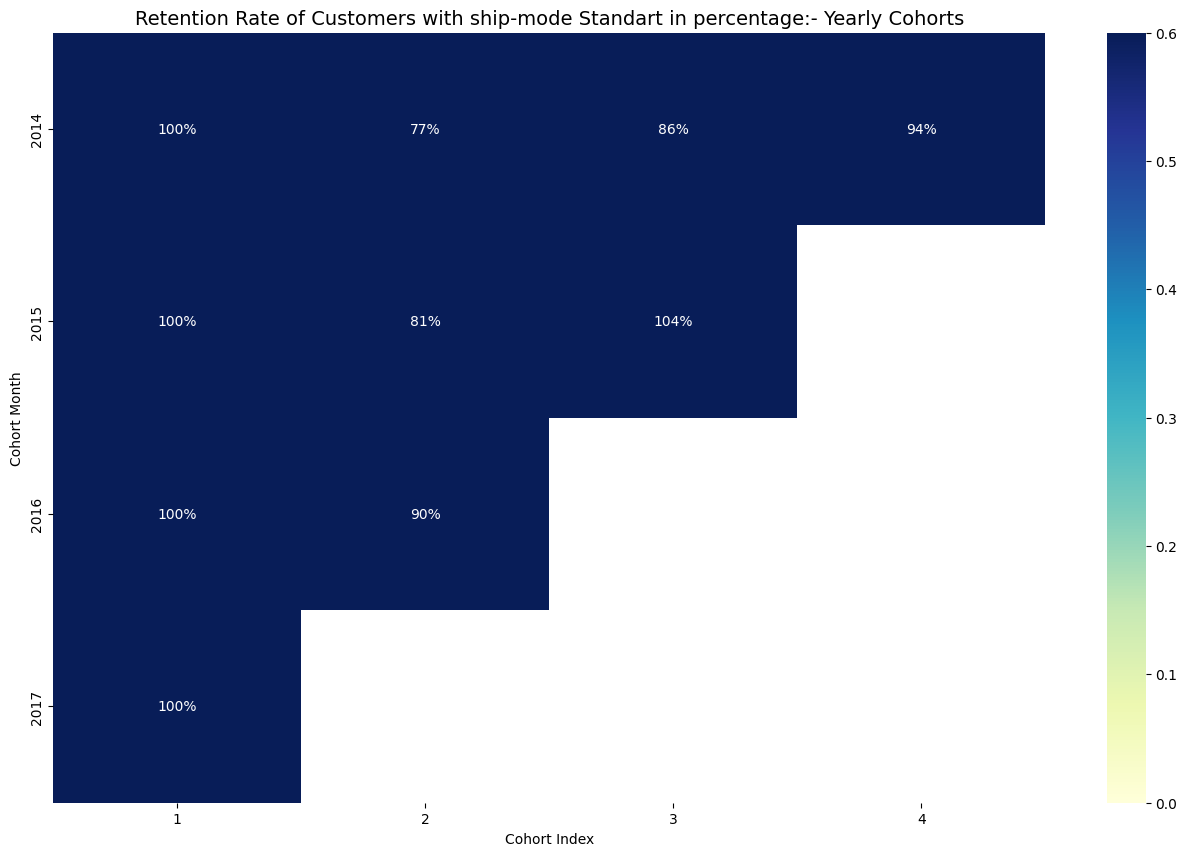

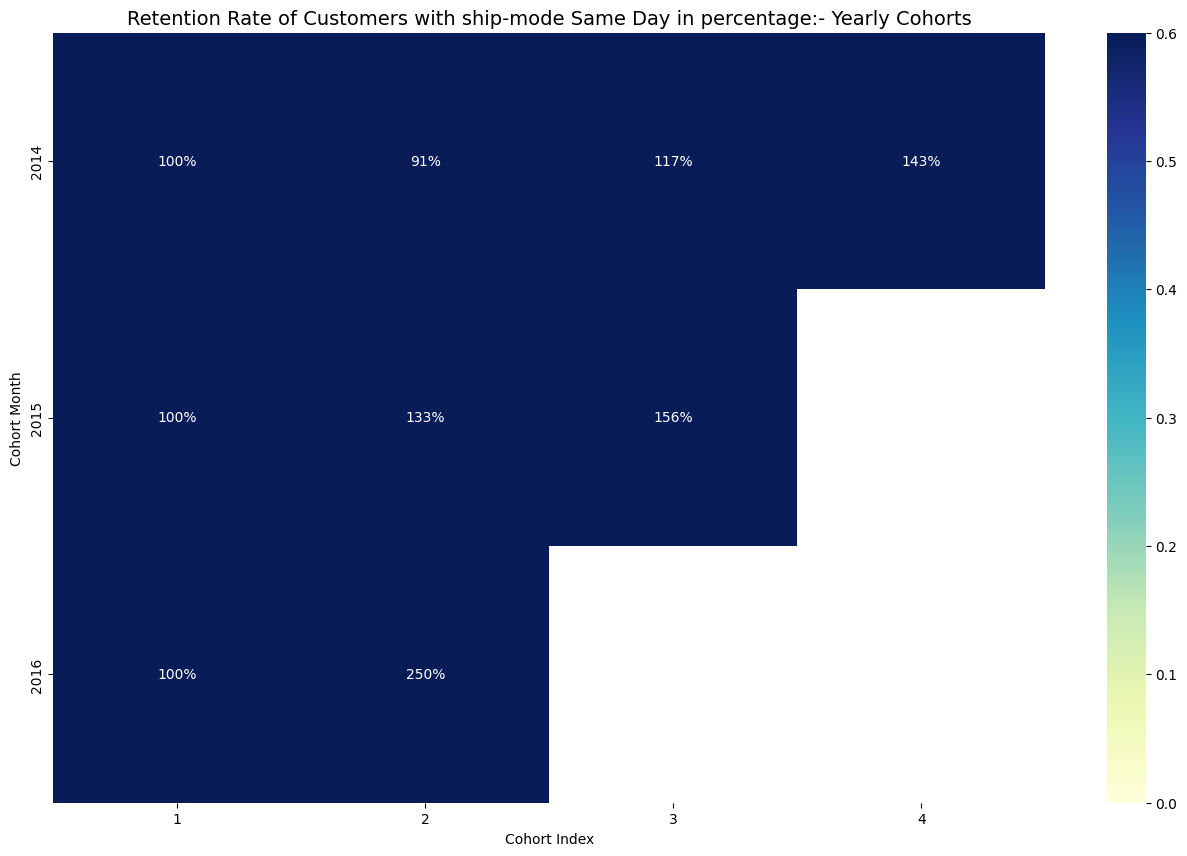

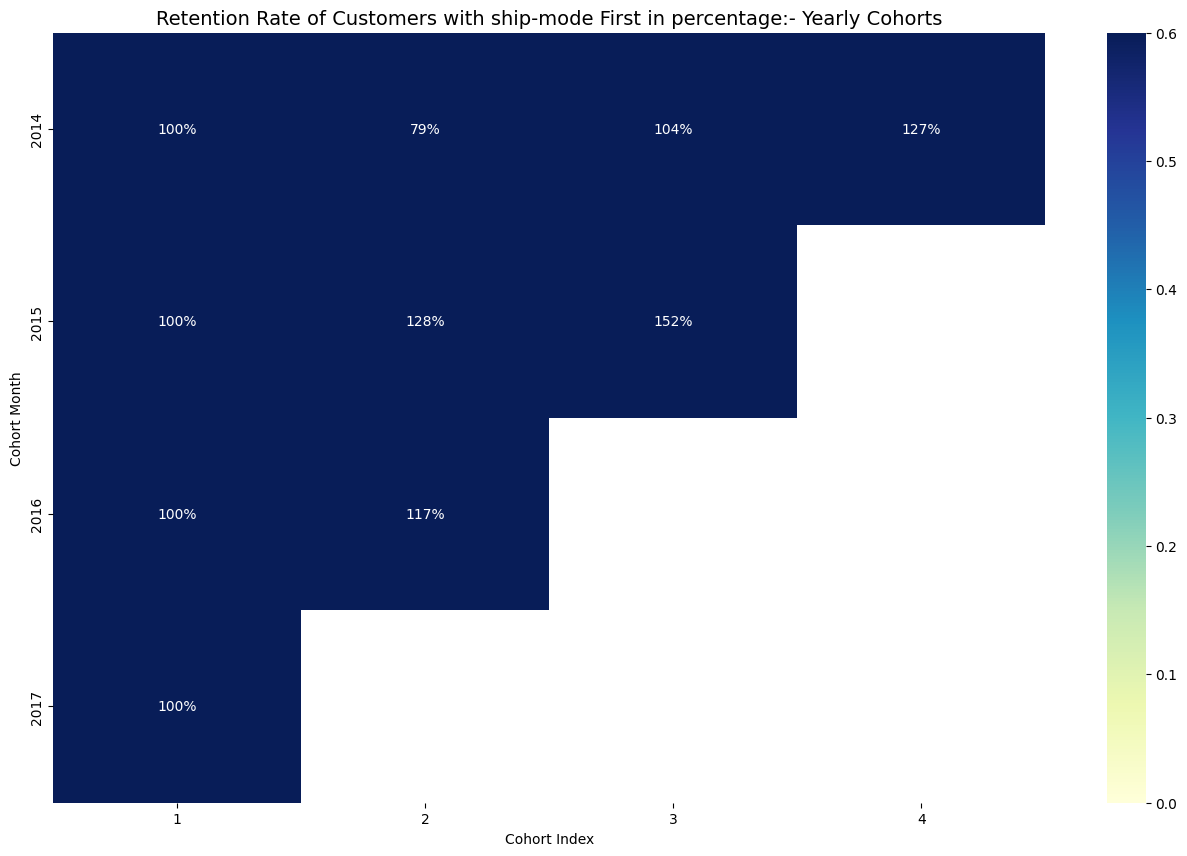

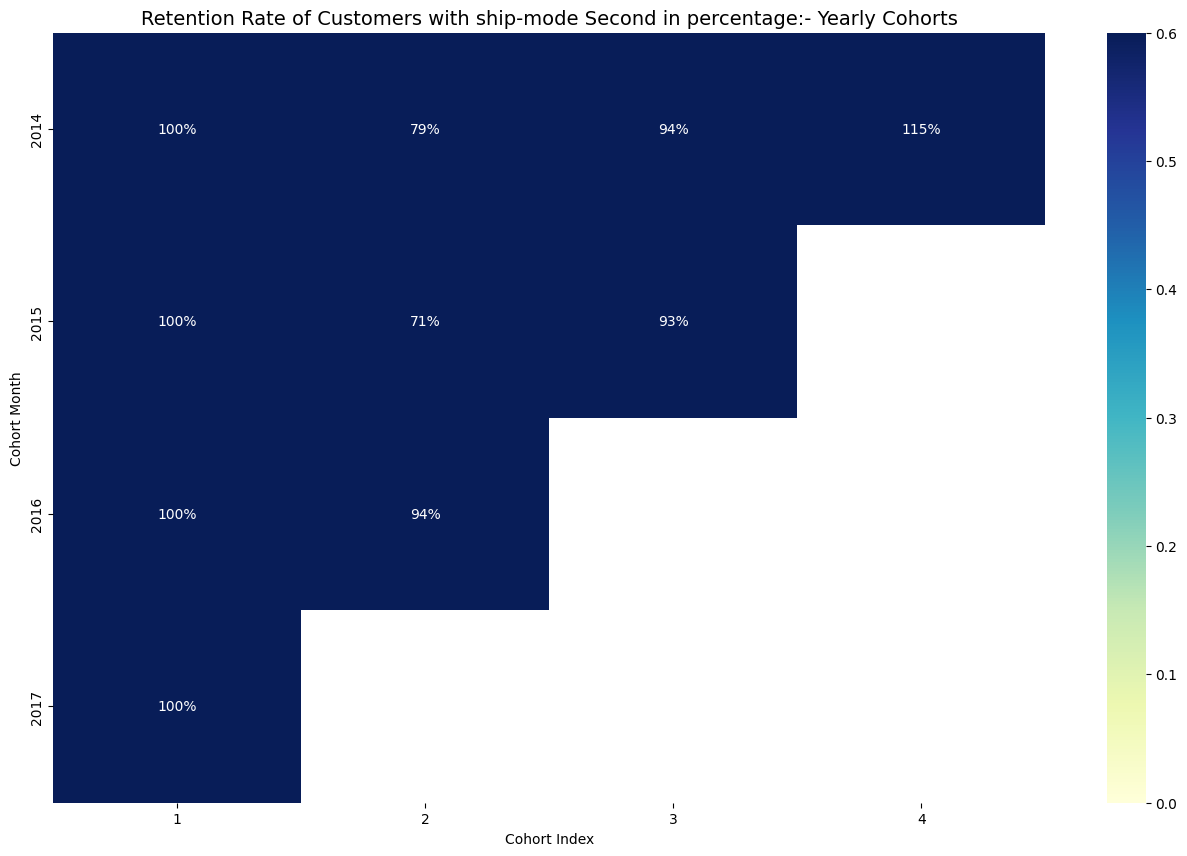

In [215]:
counter = 0
for df in [df_standart, df_sameday, df_first, df_second]:
    df['CohortIndex'] = - df['first_order'].astype(int) + df['order_year'].astype(int) + 1 
    grouping = df.groupby(['first_order', 'CohortIndex'])
    cohort_data = grouping['customer_id'].apply(pd.Series.nunique)
    cohort_data = cohort_data.reset_index()
    cohort_counts = cohort_data.pivot(index='first_order',
                                     columns ='CohortIndex',
                                     values = 'customer_id')
    cohort_sizes = cohort_counts.iloc[:,0]
    retention = cohort_counts.divide(cohort_sizes, axis=0)
    retention.round(3)*100
    plt.figure(figsize=(16, 10))
    plt.title('Retention Rate of Customers with ship-mode ' +dict_names[counter]+' in percentage:- Yearly Cohorts', fontsize = 14)
    sns.heatmap(retention, annot=True, fmt= '.0%',cmap='YlGnBu', vmin = 0.0 , vmax = 0.6)
    plt.ylabel('Cohort Year')
    plt.xlabel('Cohort Index')
    plt.yticks( rotation='vertical')
    plt.show()
    counter += 1

Тут видно, что Retention User'ов был очень неоднородным по сегментам доставки:
- Отток пользователей происходит в сегментах доставки Standart и Second.
- А сегменты Same Day и First наоборот уверенно растут на фоне 2015 года.

Напоследок посмотрю на Retention по средней сумме заказа и по сегментам доставки.

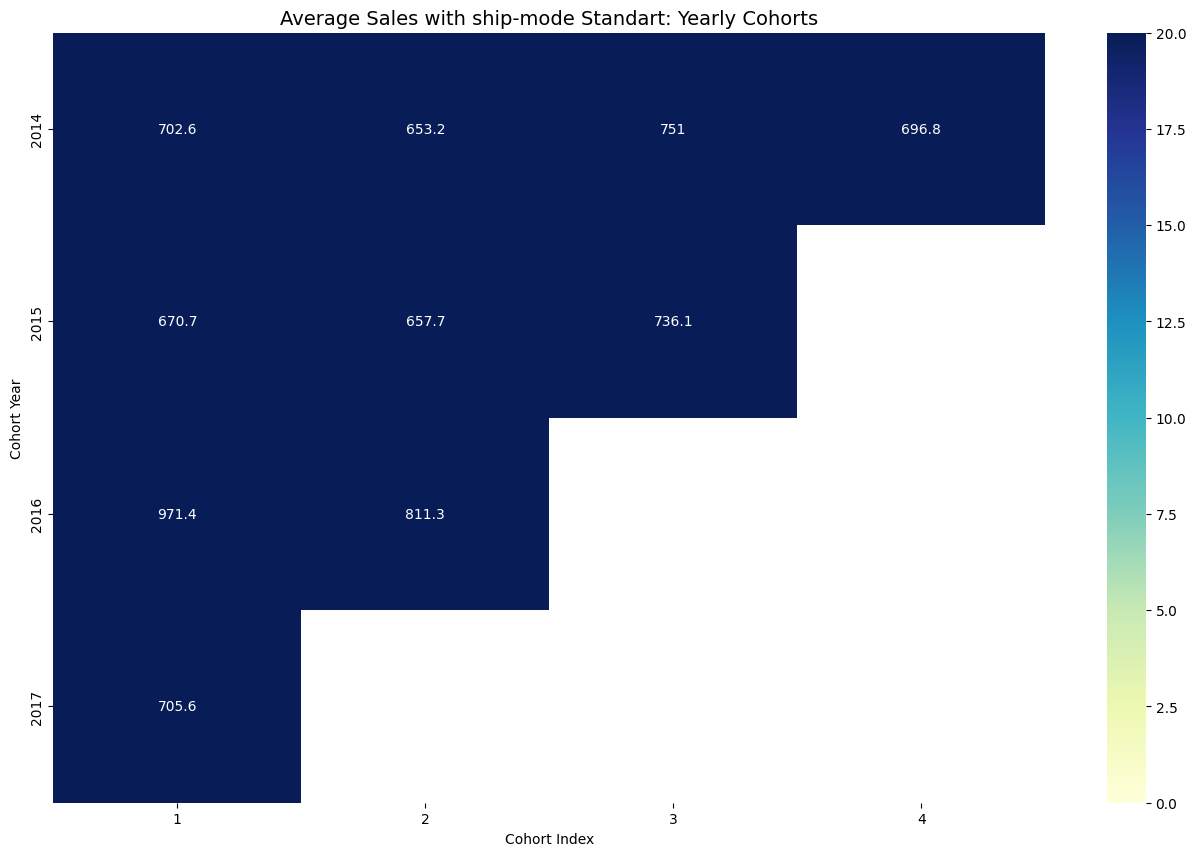

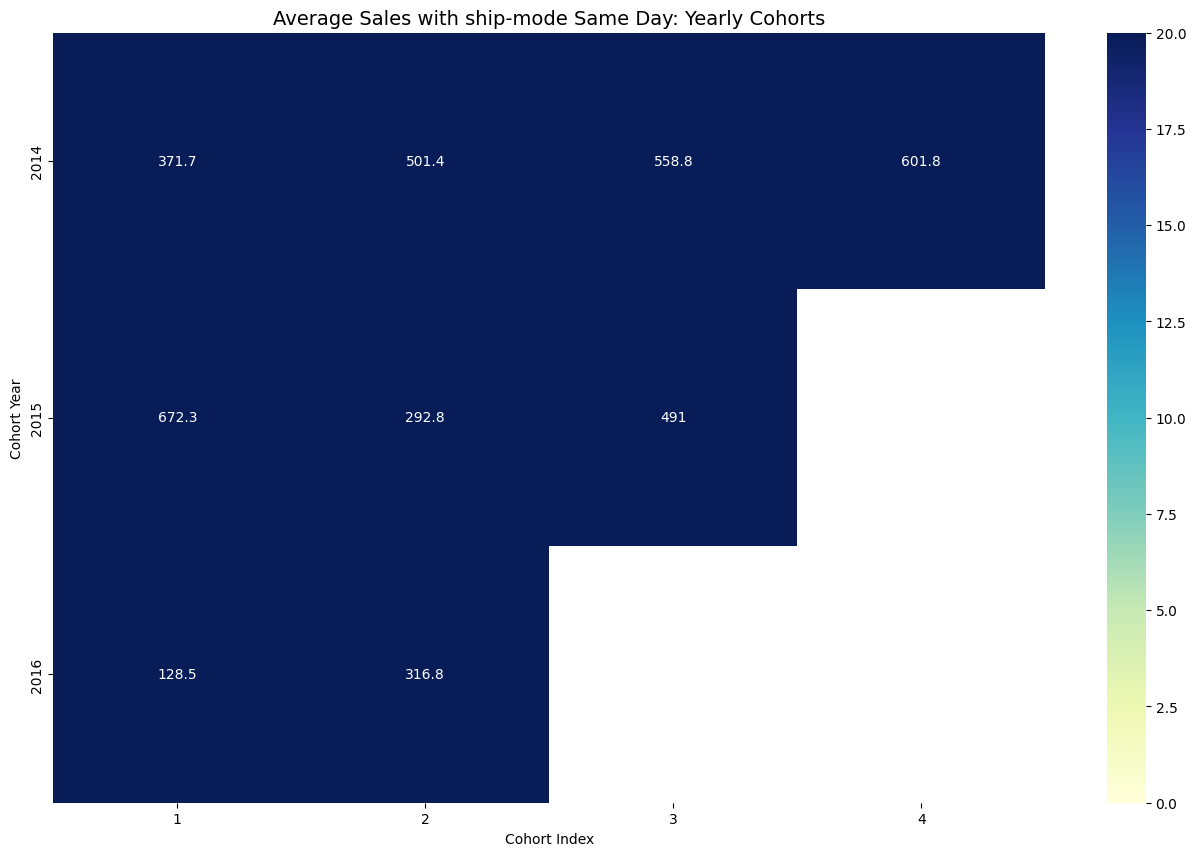

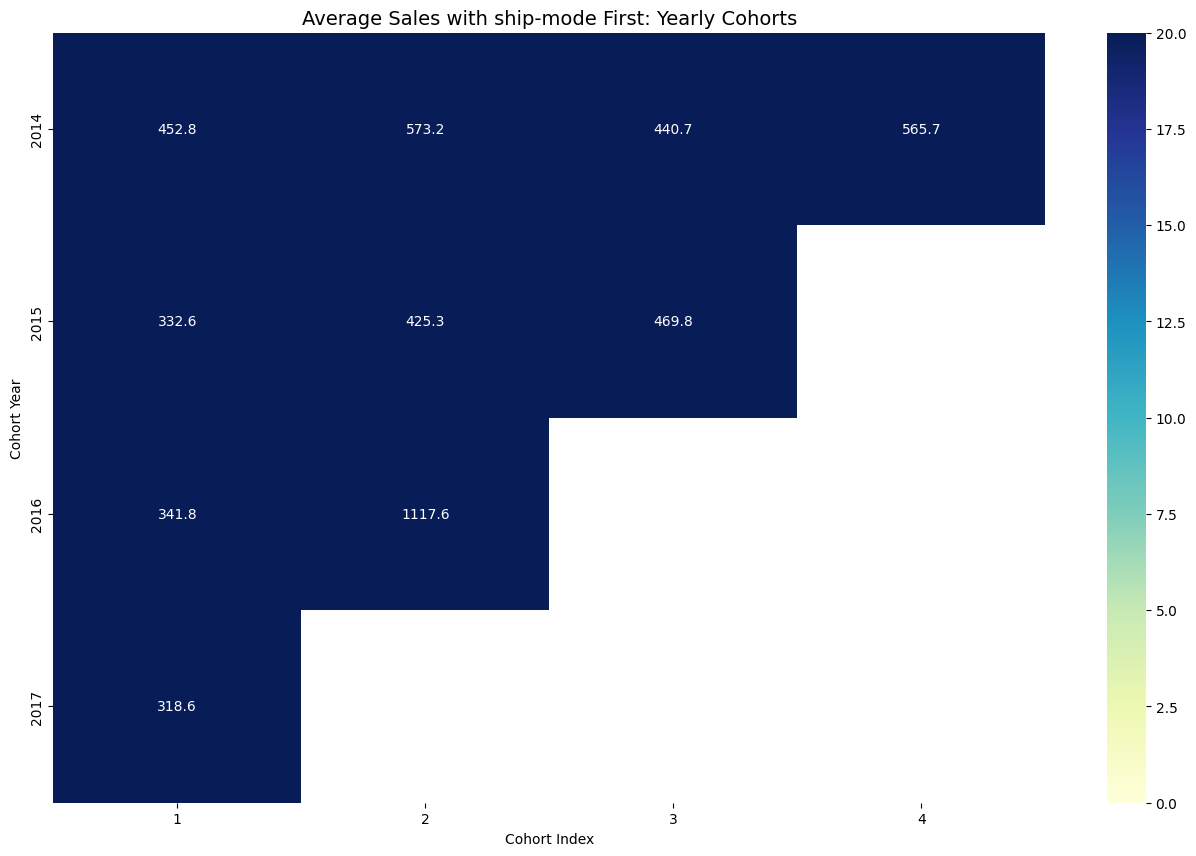

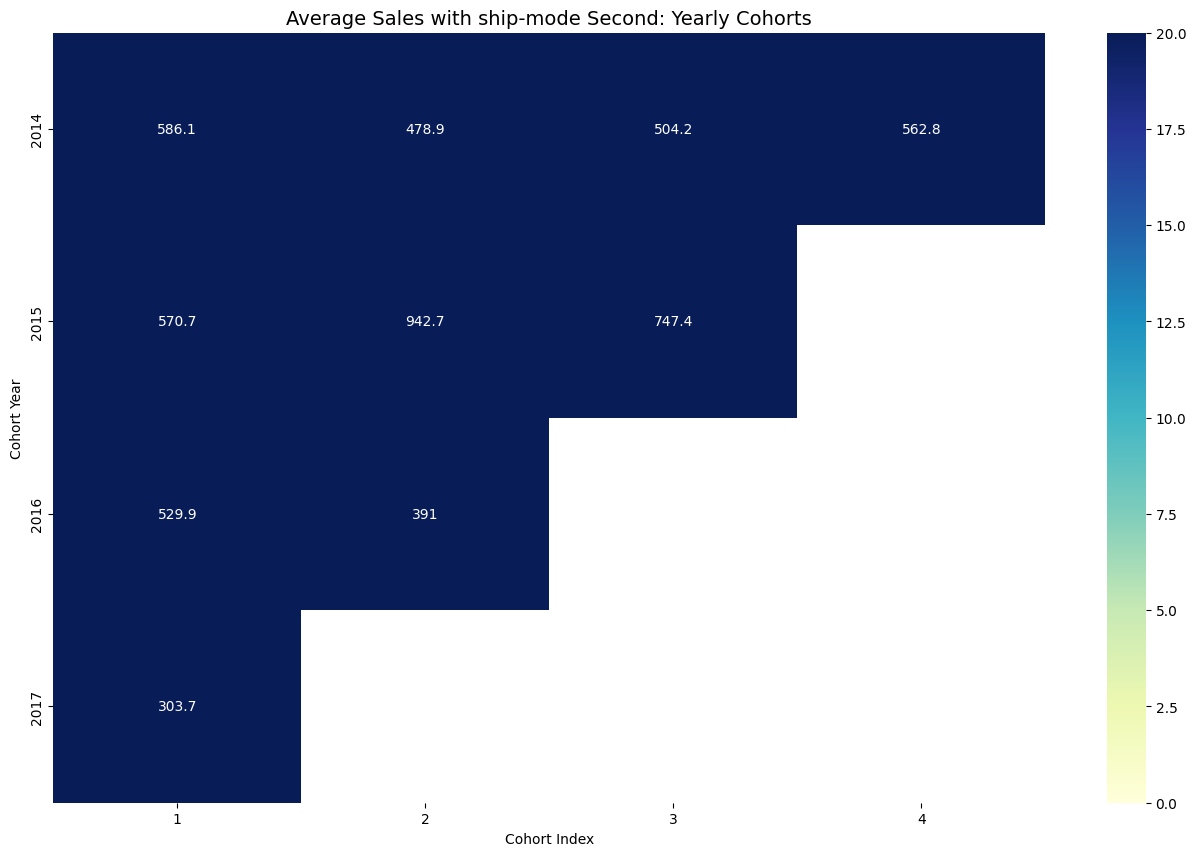

In [216]:
counter = 0
for df in [df_standart, df_sameday, df_first, df_second]:
    df['CohortIndex'] = - df['first_order'].astype(int) + df['order_year'].astype(int) + 1 
    grouping = df.groupby(['first_order', 'CohortIndex']) 
    cohort_data = grouping['sales'].mean()
    cohort_data = cohort_data.reset_index() 
    average_order = cohort_data.pivot(index='first_order',
                                  columns='CohortIndex',
                                  values='sales')

    average_standard_cost = average_order.round(1)
    plt.figure(figsize=(16, 10))
    plt.title('Average Sales with ship-mode ' +dict_names[counter]+': Yearly Cohorts', fontsize = 14)
    sns.heatmap(average_standard_cost, annot = True,vmin = 0.0, vmax =20,cmap="YlGnBu", fmt='g')
    plt.ylabel('Cohort Year')
    plt.xlabel('Cohort Index')
    plt.yticks( rotation='vertical')
    plt.show()
    counter += 1

По среднему знаечнию sales retention тоже неоднородный. 

- Существенно хуже перформит категория доставки Second. 

Также она была проблемной и в Retention'е юзеров. 


**Так что, несмотря на то, что в целом оттока нет и удержание лучше (и по юзерам, и по транзакциям, и по сумме покупки), чем в 2015 году, имеет смысл обратить дополнительное внимание на категорию доставки Second - тут есть отток пользователей и в среднем чеке. Вероятно, это и есть проблемная категория доставки.**

